<a href="https://colab.research.google.com/github/9-coding/Graduation_Project/blob/main/clothing_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf


## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []

    print(imgPath)

    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.jpg', '.png', mem))

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i])
            mask = plt.imread(maskAddr + maskNames[i])

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

file_path = '/content/drive/MyDrive/Colab Notebooks/graduation_project1/archive'

image_paths=[]
mask_paths=[]

for i in range(1000):
    image_paths.append(plt.imread(file_path + '/images/' + str(i+1).zfill(4) + '.jpg'))
    image_paths[i] = cv2.resize(image_paths[i], (256,256))
    # image_paths[i] = cv2.cvtColor(image_paths[i], cv2.COLOR_BGR2RGB)
    mask_paths.append(plt.imread(file_path + '/labels/pixel_level_labels_colored/' + str(i+1).zfill(4) + '.png'))
    mask_paths[i] = cv2.resize(mask_paths[i], (256,256))
    # mask_paths[i] = cv2.cvtColor(mask_paths[i], cv2.COLOR_BGR2RGB)

for i in range(1000):
  framObjTrain['img'].append(image_paths[i])
  framObjTrain['mask'].append(mask_paths[i])



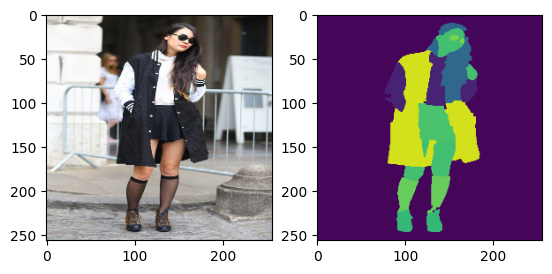

In [2]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][0])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][0])
plt.show()

In [3]:
## defining our CNN for encoding and decoding

myTransformer = tf.keras.models.Sequential([
## defining encoder
    tf.keras.layers.Input(shape= (256, 256, 3)),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'),

    ## defining decoder path
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),

    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same'),



])

myTransformer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5), loss = 'mean_absolute_error', metrics = ['acc'])

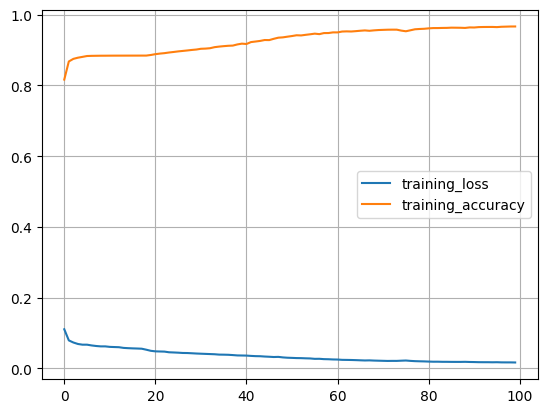

In [4]:
## trainign our model
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 100, verbose = 0)
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['acc'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [5]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [6]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)

32/32 [==============================] - 2s 50ms/step


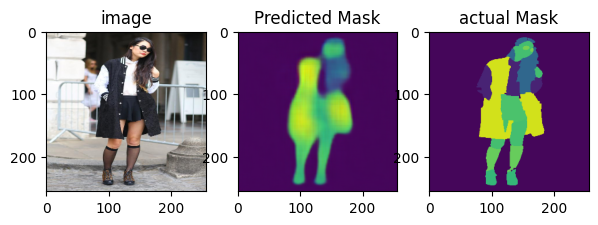

In [8]:
Plotter(actuals[0], sixteenPrediction[0], masks[0])